<a href="https://colab.research.google.com/github/ronybot/NLP_HebrewEmbeding/blob/master/CyberW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = ResNet50(weights='imagenet', include_top=False)
class image_processing():


    def _ensure_three_channels(self, img):
        """
        Ensures that the input image has 3 channels. If the image has less than 3 channels,
        it will replicate the existing channels to make it 3 channels.

        Args:
        - img (numpy.ndarray): Input image.

        Returns:
        - numpy.ndarray: Image with 3 channels.
        """

        # Check if the image is grayscale (2D array) or has only one channel
        if len(img.shape) == 2 or img.shape[2] == 1:
            return np.repeat(img[..., np.newaxis], 3, axis=-1)
        return img
    def preprocess_image(self, img_original, target_size=(224, 224)):
        img_original = img_original.resize(target_size)
        # Convert image to array
        img_array = tf.keras.preprocessing.image.img_to_array(img_original)

        # Check if the image has 4 channels (RGBA) and if so, remove the alpha channel
        if img_array.shape[-1] == 4:
            img_array = img_array[:, :, :3]
        else:
            img_array = self._ensure_three_channels(img_array)

        # Expand dimensions to match model's expected input shape
        image_batch = np.expand_dims(img_array, axis=0)


        # Use ResNet50's preprocessing function
        data = tf.keras.applications.resnet50.preprocess_input(image_batch)
        return data

    def extract_features(self,img_array):
        return base_model.predict(img_array)

In [3]:
pip install cairosvg


In [4]:

pip install boto3

In [5]:
pip install retrying

In [6]:
from PIL import Image
from io import BytesIO
import requests
import cairosvg
import xml.etree.ElementTree as ET
import boto3
import hashlib
from botocore.exceptions import ClientError
import aiohttp
import asyncio
from retrying import retry
import re
import base64
import time
import threading
import pickle
import io



# Global variable to be shared across threads


public_gatway = ['dweb.link','ipfs.io','cf-ipfs.com','gateway.pinata.cloud','cloudflare-ipfs.com']
SVG_TYPE = 'image/svg+xml'
GIF_TYPE = 'image/gif'
TEXT_TYPE = 'text/'
MP4_TYPE = 'video/mp4'

class image_download_manager:
    def __init__(self):
        self.base46_svg_pattern = re.compile(r'^data:image/svg+xml;base64')
        self.base46_str_svg_pattern = 'data:image/svg+xml;base64'
        self.base46_str_svg_pattern = 'data:image/svg+xml;base64'
        self.utf8_str_svg_pattern ='data:image/svg+xml;utf8'

    def _hash_url(self,url):
        # Create a new SHA-256 hash object
        sha256 = hashlib.sha256()

        # Update the hash object with the URL bytes
        sha256.update(url.encode('utf-8'))

        # Get the hexadecimal representation of the hash
        hashed_url = sha256.hexdigest()

        return hashed_url
    def _is_svg(self, content):
        """
        Check if the given content or file is in SVG format.
        """
        if isinstance(content, bytes):
            # Check if the content starts with '<?xml' (XML declaration)
            return content.startswith(b'<?xml') and b'svg' in content.lower()
        elif isinstance(content, str):
            # Check if the content starts with '<?xml' (XML declaration)
            return content.startswith('<?xml') and 'svg' in content.lower()
        else:
            return False  # Unsupported content type
    def _is_svg_content(self, content):
        try:
            root = ET.fromstring(content)
            return root.tag.lower() == "{http://www.w3.org/2000/svg}svg"
        except ET.ParseError:
            return False

    async def _fetch_data(self, url):
        # match = self.base46_svg_pattern.match(url)
        match = url.startswith(self.base46_str_svg_pattern) | url.startswith(self.utf8_str_svg_pattern)
        # encoded_data= None
        if match:
            data_index = url.find(',')
            if(data_index != -1):
                _data = url[data_index + 1:]
                img_content = _data if url.startswith(self.utf8_str_svg_pattern) else base64.b64decode(_data)
                im = Image.open(BytesIO(cairosvg.svg2png(img_content)))
                # encoded_data = match.group(1)
                # encoded_data =base64.b64decode(encoded_data, validate=True)
                return (im, 200, SVG_TYPE)

            return (None, 500, None)
        _start = time.time()
        timeout = aiohttp.ClientTimeout(total=15)
        async with aiohttp.ClientSession(timeout=timeout) as session:
            async with session.get(url) as response:
                _end = time.time()

                content = await response.read()
                if  response.content_type.startswith(TEXT_TYPE) or response.content_type == MP4_TYPE:
                    return (None, 500, response.content_type)
                im = Image.open(BytesIO(cairosvg.svg2png(file_obj=BytesIO(content)))) if response.content_type == SVG_TYPE else Image.open(BytesIO(content))
                return (im, response.status, response.content_type)

    async def _download_image_management(self, image_url):
        url=''
        if image_url.startswith('ipfs://'):
            for gatway in public_gatway:
                url = image_url.replace('ipfs://', f'https://{gatway}/ipfs/')
                try:
                    content, status, contentType = await self._fetch_data(url)
                    if status == 200:
                        return content, contentType
                except Exception as err:
                    print("An error occurred while downloading IPFS image_url " + image_url + " " +type(err).__name__  )
                await asyncio.sleep(10)


            return None, None
        try:
            _content, _status, _contentType = await self._fetch_data(image_url)
            if _status == 200:
                return _content, _contentType
            else:
                return None, None
        except Exception as err:

            return None, None

    def gif_to_images(self, gif_img: Image, frame_index=0):
    # Open the GIF file
        with gif_img as img:
            # Ensure the requested frame index is within the valid range
            frame_index = min(max(frame_index, 0), img.n_frames - 1)

            # Set the current frame to the requested frame
            img.seek(frame_index)

            # Convert the frame to RGB mode (optional, depending on your needs)
            rgb_frame = img.convert("RGB")

            # Return the RGB frame as a PIL Image
            return rgb_frame


    @retry(stop_max_attempt_number=3, wait_exponential_multiplier=1000, wait_exponential_max=60000)  # Max 1 minute between retries
    async def download_image(self,image_url, cache):
      try:
          img, contentType = await self._download_image_management(image_url)
          if img is None:
              return None
          if contentType == GIF_TYPE:
              img = self.gif_to_images(img)
          return img

      except Exception as err:

             return None




In [7]:
import asyncio
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import requests
from io import BytesIO
from PIL import Image
from PIL import Image


import csv

# New section

In [8]:
import asyncio
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import requests
from io import BytesIO
from PIL import Image
from PIL import Image
import asyncio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import cv2
import os

def print_image(content):

  plt.imshow(content)
  plt.axis('off')  # Turn off axis
  plt.show()

async def get_image_similarity_by_urls_compare(protected_file, suspected_fraud_file, print_image):

            plt.subplot(1, 3, 1)
            image_path =os.path.join("/content/drive/My Drive/fake_nfts/", protected_file)
            suspected_image_path =os.path.join("/content/drive/My Drive/fake_nfts/", suspected_fraud_file)

            protected_image =Image.open(image_path)
            image_processor= image_processing()

            if print_image == True:
              print_image(protected_image)

            img_protected = image_processor.preprocess_image(protected_image)
            features_protected = image_processor.extract_features(img_protected)

            plt.subplot(1, 3, 2)
            storedNftimg1_url_content  =Image.open(suspected_image_path)
            if print_image == True:
              print_image(storedNftimg1_url_content)
            img1 = image_processor.preprocess_image(storedNftimg1_url_content)
            suspected_fraud_features = image_processor.extract_features(img1)




            similarity = cosine_similarity(suspected_fraud_features, features_protected)
            if similarity is None or len(similarity) == 0:

                return None
            if similarity[0] is None or len(similarity[0]) == 0:
                return None
            return similarity[0][0]



<ipython-input-8-da93dc054bb5>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


InvalidArgumentError: Graph execution error:

Detected at node resnet50/conv1_pad/Pad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "<ipython-input-35-3d12709c5dbc>", line 25, in main

  File "<ipython-input-8-da93dc054bb5>", line 37, in get_image_similarity_by_urls_compare

  File "<ipython-input-2-6317a06bfa54>", line 45, in extract_features

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py", line 149, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 4039, in spatial_2d_padding

The first dimension of paddings must be the rank of inputs[4,2] [1,224,224,1,3]
	 [[{{node resnet50/conv1_pad/Pad}}]] [Op:__inference_predict_function_118157]

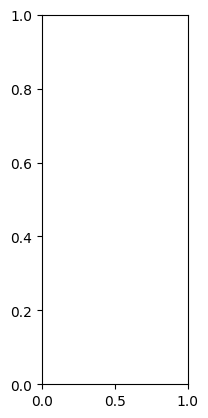

In [37]:
from matplotlib import pyplot as plt

async def main():

    # good


    dataset = "/content/drive/My Drive/fake_nfts/resnet50-dataset.csv"
    iteration =1
    fig, axs = plt.subplots(2)
    columns = 2
    i =0
    with open(dataset, 'r', newline='') as csvfile:
                csv_reader = csv.DictReader(csvfile)
                for row in csv_reader:

                  if row.get('same IMAGE URL') == "#VALUE!" and row.get('apply_method') == "grayscale" :
                    iteration +=1
                    if iteration > 20:
                      break
                    file_orig = row.get('Image2_file')
                    file_fruad = row.get('Image1_file')
                    image_similarity_score_expected = row.get('image_similarity_score')

                    similarity = await get_image_similarity_by_urls_compare(file_orig, file_fruad,False)
                    #print("Cosine similarity between the two images: " +str(float(similarity)))
                    diff =abs(float(similarity) - float(image_similarity_score_expected))


                    #print (f" {diff}   file_orig: {file_orig} file_fruad: {file_fruad} similarity: {similarity }  image_similarity_score_expected: {image_similarity_score_expected}   ")
                    if  diff > 0.02:
                      print (f" {diff}   file_orig: {file_orig} file_fruad: {file_fruad} similarity: {similarity }  image_similarity_score_expected: {image_similarity_score_expected}   ")

                      #axs[0].plot(20 / columns + 1, columns, i + 1)
                      #plt.imshow(cv2.imread((os.path.join("/content/drive/My Drive/fake_nfts/", file_orig))))

                      #axs[1].plot(20 / columns + 1, columns, i + 1)
                      #plt.imshow(cv2.imread((os.path.join("/content/drive/My Drive/fake_nfts/", file_fruad))))




loop = asyncio.get_running_loop()
await loop.create_task(main())

# New section